# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Comité de Suivi - Bag of Words

---

# Observations et environnement
---

## Environnement

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

## Données

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

In [5]:
labels = ['infox', 'entites_nommees', 'ouverture_esprit', 'faits', 'opinions',
       'propos_raportes', 'sources_citees', 'fausse_nouvelle', 'insinuations',
       'exageration', ]

In [6]:
df_label[labels].describe()

,infox,entites_nommees,ouverture_esprit,faits,opinions,propos_raportes,sources_citees,fausse_nouvelle,insinuations,exageration
count,900.000000,804.000000,803.000000,804.000000,804.000000,803.000000,803.000000,802.000000,802.000000,552.000000
mean,0.414444,0.618159,0.063512,0.717662,0.547264,0.244085,0.400996,0.152120,0.331671,0.317029
std,0.492900,0.486140,0.244033,0.450417,0.498071,0.429811,0.490406,0.359361,0.471107,0.465741
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Urls duppliquées

In [7]:
df_label.duplicated(subset='url').sum()

0

### Sites

In [8]:
df_label.value_counts('site')

site
www.francesoir.fr                    169
www.francetvinfo.fr                   91
www.breizh-info.com                   66
www.wikistrike.com                    62
lezarceleurs.blogspot.com             58
lesmoutonsrebelles.com                47
lemediaen442.fr                       32
www.profession-gendarme.com           28
lesdeqodeurs.fr                       28
fr.sott.net                           26
www.dreuz.info                        25
www.lelibrepenseur.org                23
www.polemia.com                       19
reseauinternational.net               17
actu.fr                               17
www.mondialisation.ca                 16
www.nouvelordremondial.cc             14
lesakerfrancophone.fr                 13
www.lesalonbeige.fr                   13
www.voltairenet.org                   12
lesobservateurs.ch                     9
www.anguillesousroche.com              9
lecourrier-du-soir.com                 9
www.cnews.fr                           9
www.preuves

# Experience
---

## Tf Idf Vectorizer

In [35]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenizer(t):
    return re.findall(r'[^\W\d][^\W\d]+',t)

#vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r'[^\W\d][^\W\d]+')
vectorizer = TfidfVectorizer()

## Prédiction liste de labels

In [21]:
labels = ['infox', 'entites_nommees', 'ouverture_esprit', 'faits', 'opinions',
       'propos_raportes', 'sources_citees', 'fausse_nouvelle', 'insinuations',
       'exageration', ]

In [22]:
df_ml = df_label

In [23]:
def get_df_ml(label,df_label):
    return df_label[df_label[label].notna()]

In [24]:
def get_balanced_df_ml(label,df_label):
    df_0 = df_label[df_label[label] == 0]
    df_1 = df_label[df_label[label] == 1]
    min_sample = min(len(df_0),len(df_1))
    df_0=df_0.sample(min_sample,random_state=_rs)
    df_1=df_1.sample(min_sample,random_state=_rs)
    df_ml = pd.concat([df_0,df_1])
    df_ml = df_ml.sample(frac=1,random_state=_rs)
    return df_ml

In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split

In [28]:
def get_scores(label,df_ml):
    logreg = LogisticRegression(C=100, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
    X = vectorizer.fit_transform(df_ml['text'])
    y = df_ml[label]
    classifier = logreg
    scores = cross_validate(classifier, X, y, cv=4,scoring=('roc_auc','f1','accuracy','precision','recall'))
    df_scores=pd.DataFrame(scores)
    score_dic = df_scores.mean().to_dict()
    score_dic['label']=label
    score_dic['n_samples']=len(df_ml)
    return score_dic

In [29]:
score_list = []
for label in labels:
    print(f'Processing {label}')
    df_ml = get_balanced_df_ml(label,df_label)
    score_list.append(get_scores(label,df_ml))

Processing infox
Processing entites_nommees
Processing ouverture_esprit
Processing faits
Processing opinions
Processing propos_raportes
Processing sources_citees
Processing fausse_nouvelle
Processing insinuations
Processing exageration


In [30]:
df_results = pd.DataFrame(score_list).set_index('label')

In [31]:
pd.set_option('display.precision',3)

In [32]:
df_results.drop(columns=['fit_time','score_time'])

,test_roc_auc,test_f1,test_accuracy,test_precision,test_recall,n_samples
label,,,,,,
infox,0.853,0.768,0.772,0.782,0.756,746
entites_nommees,0.751,0.699,0.708,0.727,0.677,614
ouverture_esprit,0.555,0.435,0.480,0.470,0.410,102
faits,0.668,0.618,0.619,0.620,0.617,454
opinions,0.757,0.683,0.692,0.706,0.662,728
propos_raportes,0.615,0.574,0.584,0.591,0.561,392
sources_citees,0.614,0.564,0.570,0.574,0.556,644
fausse_nouvelle,0.663,0.669,0.660,0.652,0.688,244
insinuations,0.772,0.698,0.703,0.708,0.691,532


/var/folders/fr/mhrqmk5n1xs49b7jl3tgs2r00000gn/T/ipykernel_7708/1380019141.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'infox'),
 Text(1, 0, 'entites_nommees'),
 Text(2, 0, 'ouverture_esprit'),
 Text(3, 0, 'faits'),
 Text(4, 0, 'opinions'),
 Text(5, 0, 'propos_raportes'),
 Text(6, 0, 'sources_citees'),
 Text(7, 0, 'fausse_nouvelle'),
 Text(8, 0, 'insinuations'),
 Text(9, 0, 'exageration')]

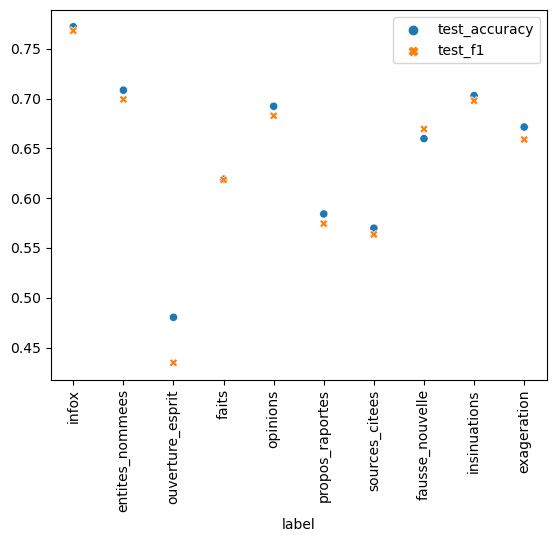

In [33]:
plot = sns.scatterplot(df_results[['test_accuracy','test_f1']])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

/var/folders/fr/mhrqmk5n1xs49b7jl3tgs2r00000gn/T/ipykernel_7708/617114656.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'infox'),
 Text(1, 0, 'entites_nommees'),
 Text(2, 0, 'ouverture_esprit'),
 Text(3, 0, 'faits'),
 Text(4, 0, 'opinions'),
 Text(5, 0, 'propos_raportes'),
 Text(6, 0, 'sources_citees'),
 Text(7, 0, 'fausse_nouvelle'),
 Text(8, 0, 'insinuations'),
 Text(9, 0, 'exageration')]

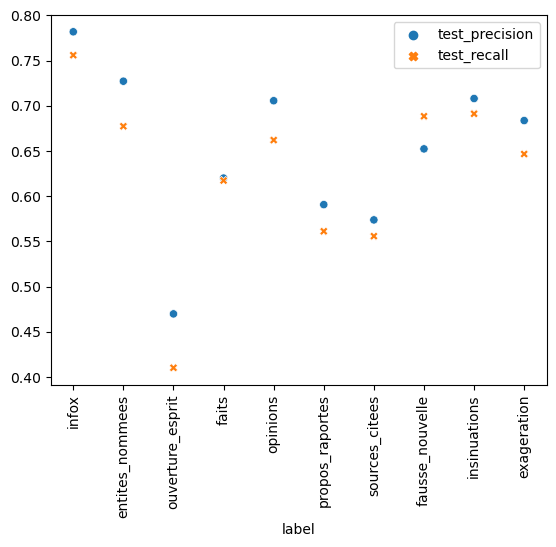

In [34]:
plot = sns.scatterplot(df_results[['test_precision','test_recall']])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

# Sauvegarde des résultats
---

# Conclusions
---

# Bricolages
---